# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'

NOTE: Pytorch expects input to be in NxCxHxW for convolution and pooling layer i.e.
- N: No of images
- C: No of channels
- H: Height of Image
- W: Width of Image

# Hyperparameters

In [2]:
n_channels = 1
epochs = 50
batch_size = 64
learning_rate = 0.001
p = 0.3

# Loading Data

In [3]:
base_folder = './data'
fashion_mnist_train = datasets.FashionMNIST(base_folder, download = True, train = True)
train_images, train_labels = fashion_mnist_train.data, fashion_mnist_train.targets
fashion_mnist_valid = datasets.FashionMNIST(base_folder, download = True, train = False)
valid_images, valid_labels = fashion_mnist_valid.data, fashion_mnist_valid.targets

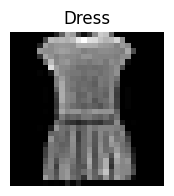

In [4]:
idx = 3
img, lbl = train_images[idx], train_labels[idx]
plt.figure(figsize = (2,2))
plt.imshow(img, cmap = 'gray')
plt.title(fashion_mnist_train.classes[lbl])
plt.axis('off');

In [5]:
class FMNISTDataset(Dataset):
    def __init__(self, imgs, lbls):
        # Flattening image
        self.imgs = imgs
        self.lbls = lbls
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img, lbl = self.imgs[idx], self.lbls[idx]
        
        # Normalize input image to be in between 0-1
        img = img / 255.
        
        # Add Channel Dimension (fake dimension)
        img = img[None, :, :]
        return img, lbl

In [6]:
def get_data(bs = 64):
    train_data = FMNISTDataset(train_images, train_labels)
    trainloader = DataLoader(train_data, batch_size = bs, shuffle = True)
    valid_data = FMNISTDataset(valid_images, valid_labels)
    validloader = DataLoader(valid_data, batch_size = bs)
    return trainloader, validloader

def build_model(p = 0.5, n_channels = 1, lr = 1e-03):
    # Architecture inspired from LeNet (Source: http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf)
    # Slight modification compared to original LeNet Paper
    
    model = nn.Sequential(nn.Conv2d(n_channels, out_channels = 6, kernel_size = 5, stride = 1),
                          nn.MaxPool2d(kernel_size = 2, stride = 2),
                          nn.ReLU(),
                          nn.Dropout(p),
                          nn.Conv2d(6, out_channels = 16, kernel_size = 5, stride = 1),
                          nn.MaxPool2d(kernel_size = 2, stride = 2),
                          nn.ReLU(),
                          nn.Flatten(),
                          nn.Dropout(p),
                          nn.Linear(256, 120),
                          nn.ReLU(),
                          nn.Dropout(p),
                          nn.Linear(120, 84),
                          nn.ReLU(),
                          nn.Dropout(p),
                          nn.Linear(84, 10))
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    return model, criterion, optimizer

def train_batch(imgs, lbls, model, criterion, optimizer, valid = False):
    optimizer.zero_grad()
    imgs, lbls, model = imgs.to(device), lbls.to(device), model.to(device)
    out = model(imgs)
    batch_loss = criterion(out, lbls)
    if not valid:
        batch_loss.backward()
        optimizer.step()
    return batch_loss.item()

def no_of_correct(imgs, lbls, model):
    imgs, lbls, model = imgs.to(device), lbls.to(device), model.to(device)
    with torch.no_grad():
        model.eval()
        out = model(imgs)
        _, preds= out.max(-1)
        correct_preds = preds == lbls
        return correct_preds.cpu().numpy().sum(), len(lbls)

In [7]:
def train(p, epochs, learning_rate):
    trainloader, validloader = get_data(batch_size)
    model, criterion, optimizer = build_model(p, lr = learning_rate)
    train_accuracies, valid_accuracies = [], []
    train_losses, valid_losses = [], []
    for epoch in range(epochs+1):
        batch_loss = 0.0
        model.train()
        for imgs, lbls in trainloader:
            batch_loss += train_batch(imgs, lbls, model, criterion, optimizer)

        total_correct = 0
        total = 0
        for imgs, lbls in trainloader:
            batch_correct, batch_total = no_of_correct(imgs, lbls, model)
            total_correct += batch_correct
            total += batch_total

        epoch_train_acc = total_correct/total
        train_accuracies.append(epoch_train_acc)
        epoch_train_loss = batch_loss / len(trainloader)
        train_losses.append(epoch_train_loss)

        # Calculating for Valid data
        batch_loss = 0.0
        total_correct = 0
        total = 0
        for imgs, lbls in validloader:
            batch_loss += train_batch(imgs, lbls, model, criterion, optimizer, valid = True)
            batch_correct, batch_total = no_of_correct(imgs, lbls, model)
            total_correct += batch_correct
            total += batch_total

        epoch_valid_loss = batch_loss / len(validloader)
        epoch_valid_acc = total_correct / total
        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_acc)

        if epoch % 5 == 0:
            print(f"{'*'*10} EPOCH {epoch:2}/{epochs} {'*'*10}")
            print(f'''{"#"*33}
Train Loss: {epoch_train_loss:5.3f}, Train Accuracy: {epoch_train_acc*100:5.2f}
Valid Loss: {epoch_valid_loss:5.3f}, Valid Accuracy: {epoch_valid_acc*100:5.2f}
{"#"*33}''')
        
    return model, train_losses, train_accuracies, valid_losses, valid_accuracies

In [8]:
model, _, _ = build_model()
summary(model, torch.rand(32, 1, 28, 28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 24, 24]           156
├─MaxPool2d: 1-2                         [-1, 6, 12, 12]           --
├─ReLU: 1-3                              [-1, 6, 12, 12]           --
├─Dropout: 1-4                           [-1, 6, 12, 12]           --
├─Conv2d: 1-5                            [-1, 16, 8, 8]            2,416
├─MaxPool2d: 1-6                         [-1, 16, 4, 4]            --
├─ReLU: 1-7                              [-1, 16, 4, 4]            --
├─Flatten: 1-8                           [-1, 256]                 --
├─Dropout: 1-9                           [-1, 256]                 --
├─Linear: 1-10                           [-1, 120]                 30,840
├─ReLU: 1-11                             [-1, 120]                 --
├─Dropout: 1-12                          [-1, 120]                 --
├─Linear: 1-13                           [-1, 84]                  10,164
├─R

In [ ]:
model, train_losses, train_accuracies, valid_losses, valid_accuracies = train(p, epochs, learning_rate)

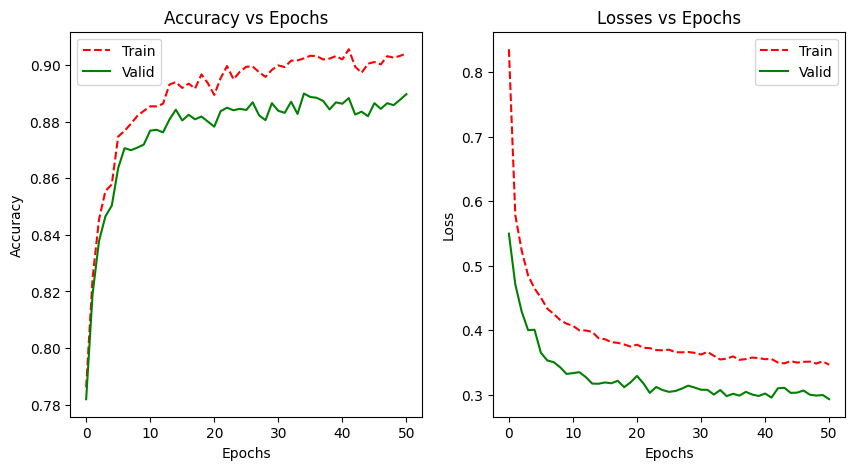

In [13]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, 'r--', label = 'Train')
plt.plot(valid_accuracies, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();

# CNN impact on translation

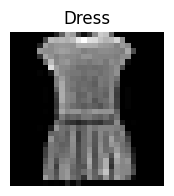

In [11]:
idx = 3
img, lbl = train_images[idx], train_labels[idx]
plt.figure(figsize = (2,2))
plt.imshow(img, cmap = 'gray')
plt.title(fashion_mnist_train.classes[lbl])
plt.axis('off');

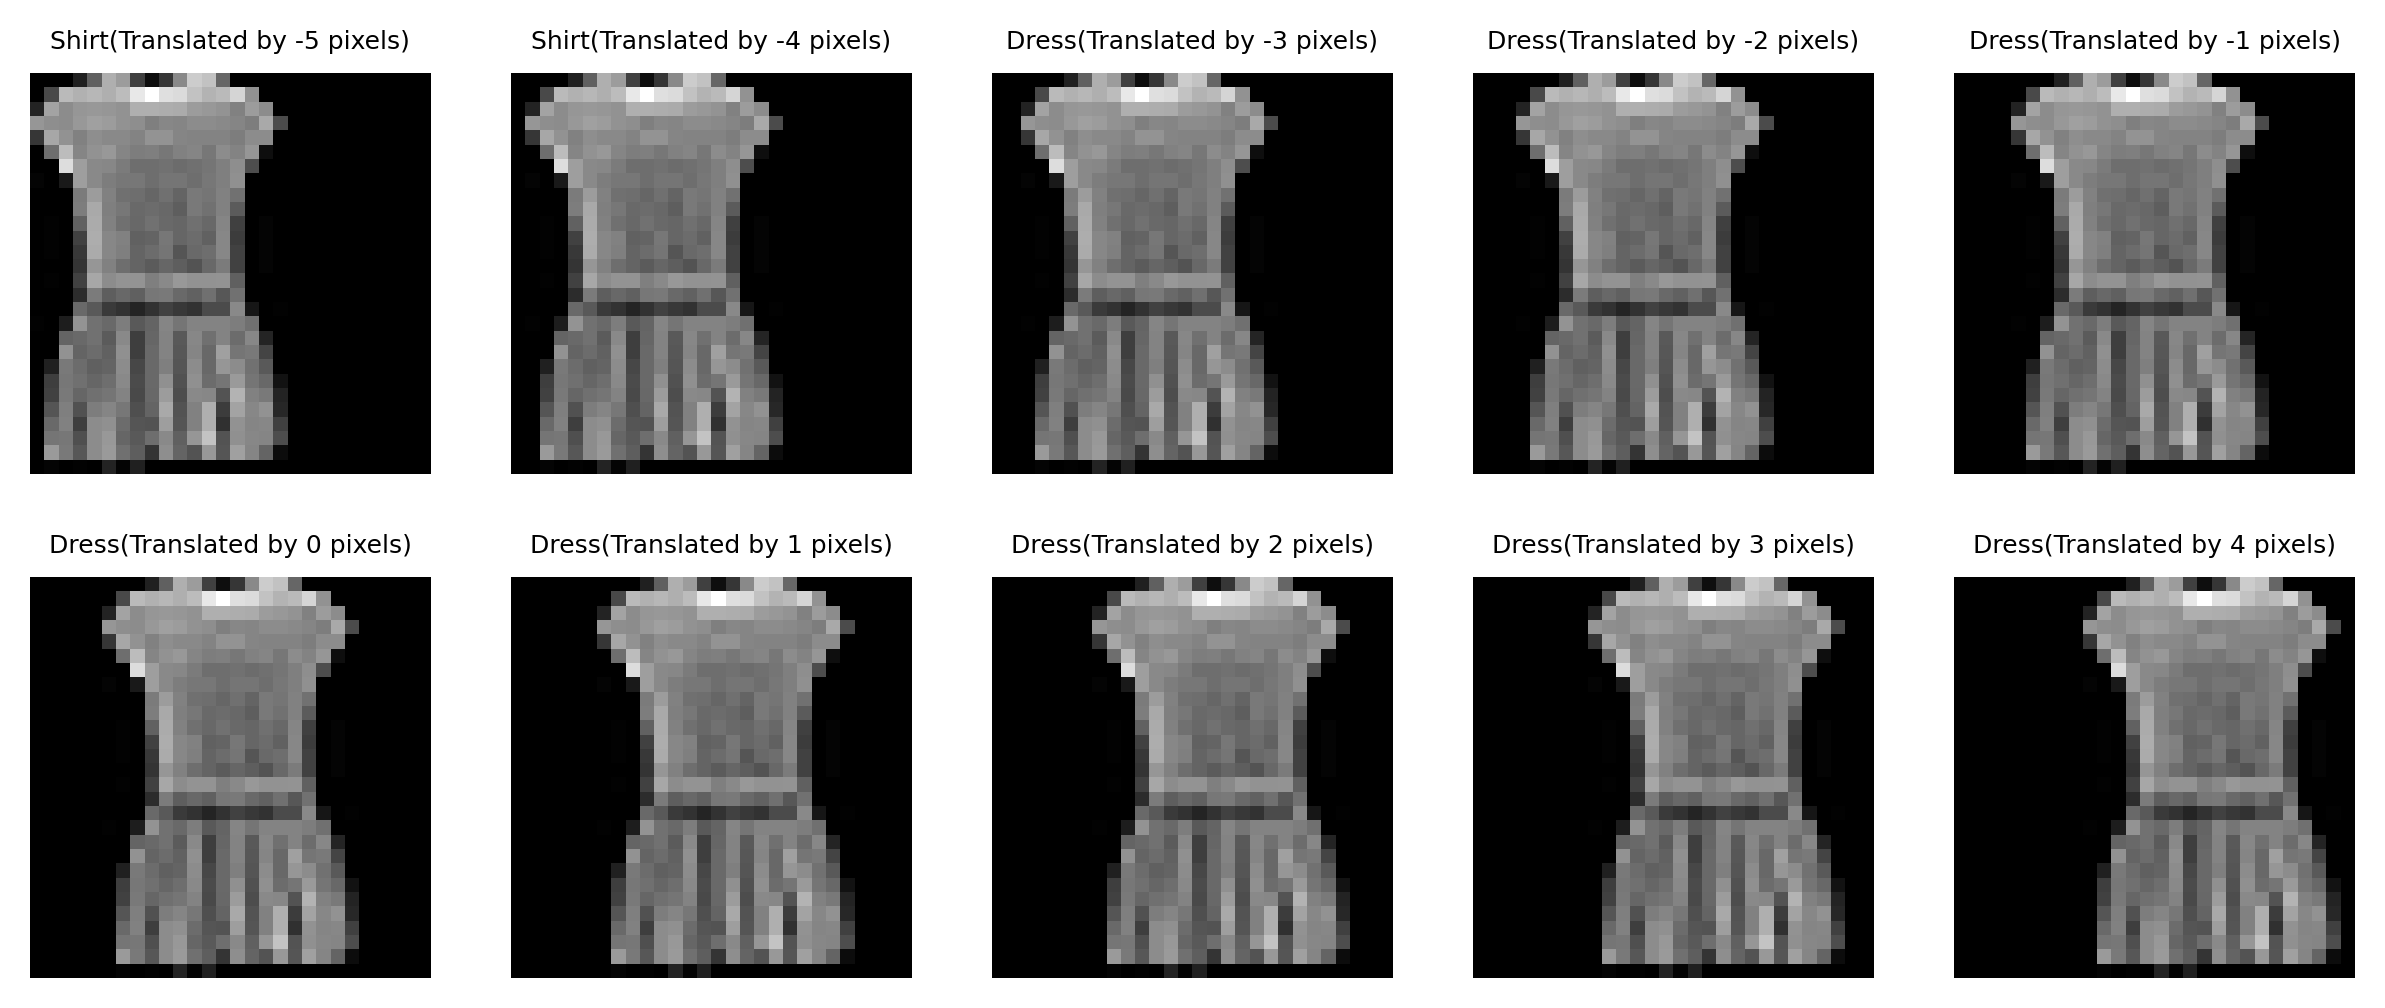

In [12]:
n = 5
h,w = img.shape
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (10,4), dpi = 300)
idx = 0
for i in range(-n, n):
    translated_tensor = torch.zeros_like(img)
    if i < 0:
        translated_tensor[:,:w+i] = img[:,-i:]
    if i == 0:
        translated_tensor[:,:] = img[:, :]
    if i>0:
        translated_tensor[:,i:] = img[:,:-i]
        
    final_img = translated_tensor.to(device) / 255.
    final_img = final_img[None, None, :, :]
    preds = model(final_img)
    label_predicted = fashion_mnist_train.classes[torch.max(preds, -1)[-1].item()]
    axes[idx//5, idx%5].imshow(translated_tensor, cmap = 'gray')
    axes[idx//5, idx%5].axis('off')
    axes[idx//5, idx%5].set_title(label_predicted+f'(Translated by {i} pixels)', fontsize = 6)
    idx+=1

So the prediction by cnn is better than classical ann in terms of translation. Though there is wrongly predicted class with -5 and -4 pixels translation. This can easily be taken care of by introducing data augmentation which introduces random different transformation (such as translation, rotation, shearing, etc.) to each data which can be encountered by the deep learning model in the real world and thus allow model to be trained in such scenario and perform better in real world. These augmentation is applied at each iteration to all data and thus a particular image is encountered in different transformation by the model, making it more robust.

__NOTE:__ I will be using Kornia for transformations. Other libraries which can also be used are torchvision, opencv, albumnetation, imgaug, etc.

# Image Augmentations

In [16]:
import kornia as K
import kornia.geometry.transform as transforms

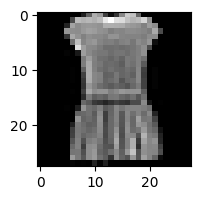

In [20]:
plt.figure(figsize = (2,2))
plt.imshow(img, cmap = 'gray');

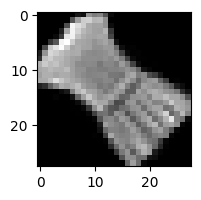

In [29]:
# Rotation
angle = torch.Tensor([45.])
img_with_batch = img[None, None, :, :].to(torch.float32) # Input should be of form BxCxHxW
rotated = transforms.rotate(img_with_batch, angle)
plt.figure(figsize = (2,2))
plt.imshow(rotated[0][0], cmap = 'gray');

In [ ]:
# Translation

